In [1]:
import cv2
import numpy as np
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import sys
# Add the project root directory to the Python path
sys.path.append('../')

from src.utils.config import MODEL_DIR, DATA_DIR

yolo_model = MODEL_DIR / "yolov3.weights"
yolo_config = MODEL_DIR / "yolov3.cfg"
labels_path = MODEL_DIR / "yolov3.names"

LABELS = open(labels_path).read().strip().split("\n")

np.random.seed(42)
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3),
    dtype="uint8")

print("[INFO] loading YOLO model...")
net = cv2.dnn.readNetFromDarknet(yolo_config.as_posix(), yolo_model.as_posix())

# determine only the *output* layer names that we need from YOLO
ln = net.getLayerNames()
ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]

[INFO] loading YOLO model...


In [2]:
def human_localization(input_video):
    # Human localization inference
    vidcapture = cv2.VideoCapture(input_video.as_posix())
    count = 0
    while 1:
        success, image = vidcapture.read()
        if not success:
            break
        count += 1
        (H, W) = image.shape[:2]

        blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416), swapRB=True, crop=False)

        # construct a blob from the input image and then perform a forward
        # pass of the YOLO object detector, giving us our bounding boxes and
        # associated probabilities
        net.setInput(blob)

        #run net
        layerOutputs = net.forward(ln)

        boxes = []
        confidences = []
        classIDs = []
        number = 0
        # output are grids ( 13 * 13 * 3 ) in (13 * 13 * 3 * yolo layers)
        for output in layerOutputs:

            #detections are outputs of each anchor for each grid (85) in (85 * 3)
            for detection in output:

                # extract the class ID and confidence (i.e., probability) of
                # the current object detection
                scores = detection[5:]
                classID = np.argmax(scores)
                confidence = scores[classID]
                if confidence > 0.5:
                    box = detection[0:4] * np.array([W, H, W, H])
                    (centerX, centerY, width, height) = box.astype("int")

                    x = int(centerX - (width / 2))
                    y = int(centerY - (height / 2))

                    boxes.append([x, y, int(width), int(height)])
                    confidences.append(float(confidence))
                    classIDs.append(classID)

        idxs = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.3)
        if len(idxs) > 0:
            for i in idxs.flatten():
                (x, y) = (boxes[i][0], boxes[i][1])
                (w, h) = (boxes[i][2], boxes[i][3])

                color = [int(c) for c in COLORS[classIDs[i]]]
                if LABELS[classIDs[i]] == 'person':
                    number+=1
                    cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
                    text = "{}: {:.4f}".format(LABELS[classIDs[i]], confidences[i])
                    cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,
                                    0.5, color, 2)

        if count % 30 == 0:
            img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            plt.imshow(img_rgb)
            plt.axis('off')  # Optional: Hides the axis ticks and labels
            plt.show()

        # cv2.imshow("frame",image)
        # cv2.waitKey(1)

    cv2.destroyAllWindows()


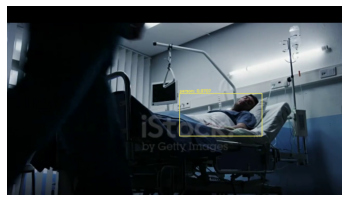

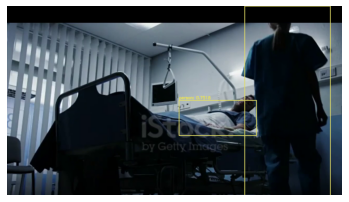

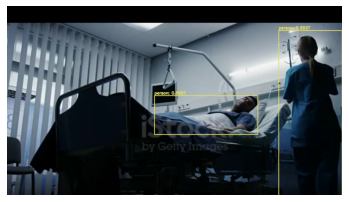

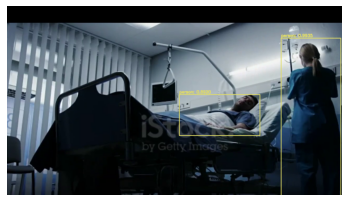

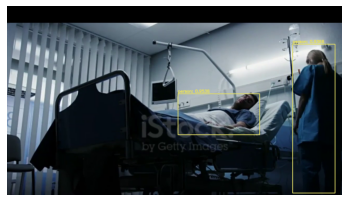

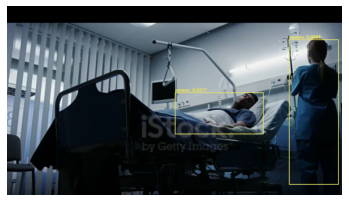

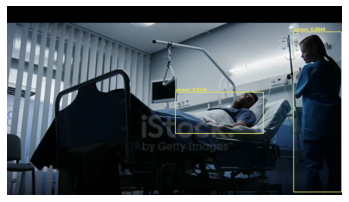

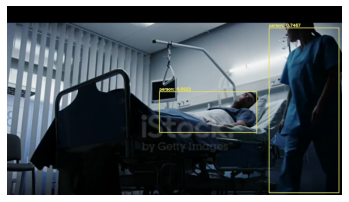

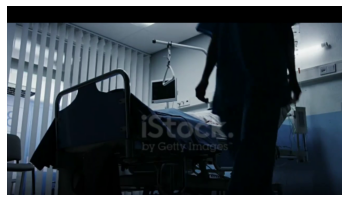

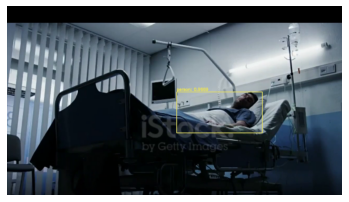

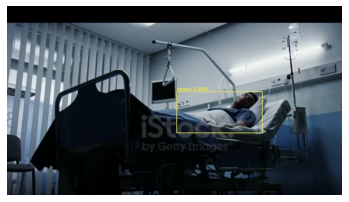

In [5]:
input_video = input_video = DATA_DIR / "human_localization_2.mp4"
human_localization(input_video)

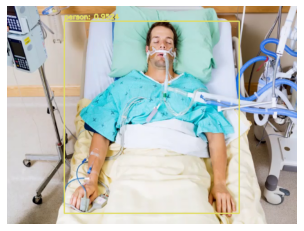

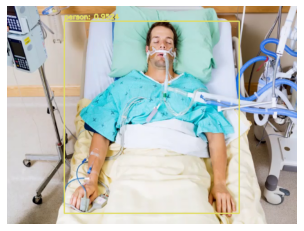

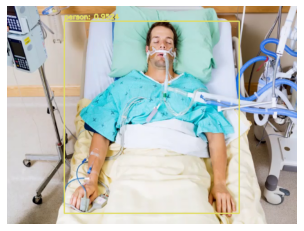

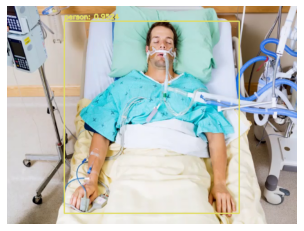

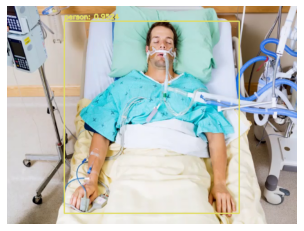

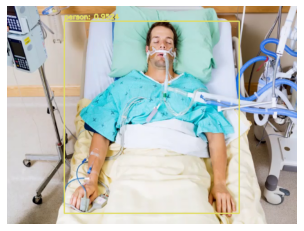

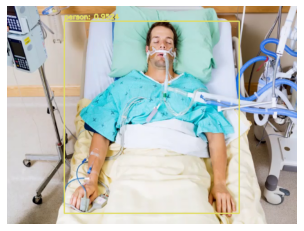

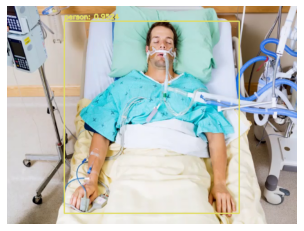

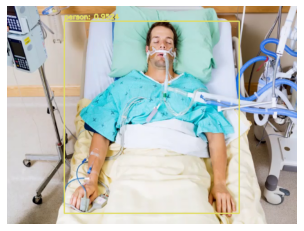

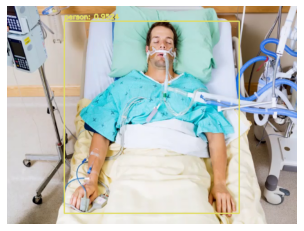

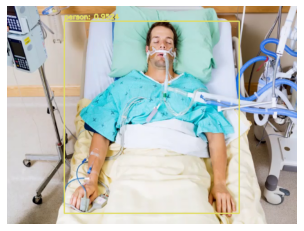

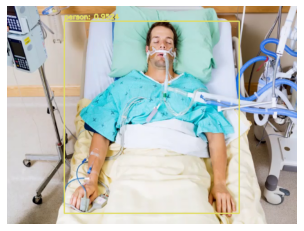

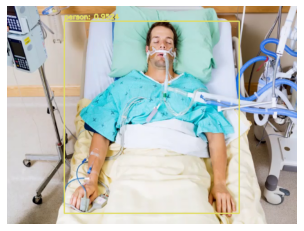

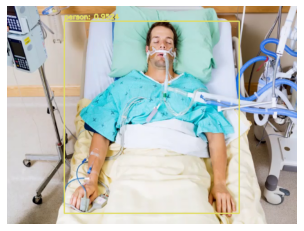

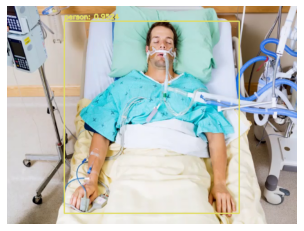

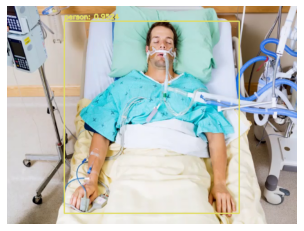

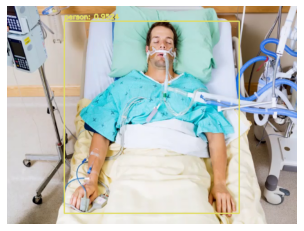

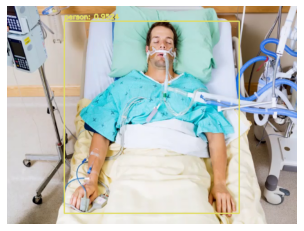

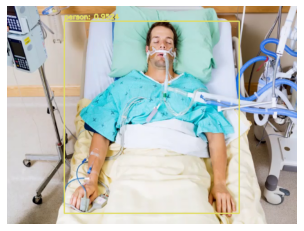

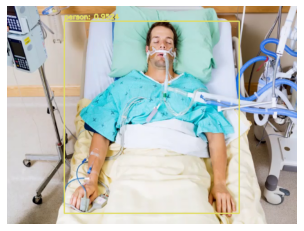

In [6]:
input_video = input_video = DATA_DIR / "human_localization_1.mp4"
human_localization(input_video)